Compute and store the mf full graph susceptibility for different parameters to explore what factors make a good influence strategy.

Created on: 12/02/21

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import random
import itertools
import matplotlib
from scipy import stats
import math

from ising_block_level_influence import N_Block_sbm_class as NBlock
from ising_block_level_influence import projection_simplex as proj
from ising_block_level_influence import mean_field_IIM
from spatial_spin_monte_carlo import spatial_spin_monte_carlo as Spins
import Pokec_processing as  PokProc

from pokec_utils import *

In [2]:
graph = nx.read_graphml('Data/Bratislava_graph.graphml')
beta_c = Spins.crit_beta_sparse(graph)
bratislava_profiles = pd.read_csv("Data/bratislava_profiles.csv")
coupling_graph = nx.read_graphml('Data/Bratislava_coupling.graphml')
block_data = pd.read_csv('Data/block_info.csv',converters={'Block' : ast.literal_eval})
mean_block_ages = list(block_data['average_age'])
block_sizes = list(block_data['block_size'])
block_names = list(block_data['block_name'])
block_data['age_group'] = [ 'ages_' + k.split('_')[-1] for k in list(block_data['block_name'])]
block_data.head()

Computing critical temperature


,Unnamed: 0,block_name,block_size,average_age,age_group
0,0,Okolie_ages_1-17,1234,9.0,ages_1-17
1,1,Okolie_ages_18-21,1939,19.5,ages_18-21
2,2,Okolie_ages_22-28,3154,25.0,ages_22-28
3,3,Okolie_ages_29-112,3458,70.5,ages_29-112
4,4,Petrzalka_ages_1-17,1398,9.0,ages_1-17


In [ ]:
def linear_field(x : np.ndarray,gradient :float) :
    return gradient*x
#Scale ages to [-1,1]:
rescaled_ages = [ (k-np.mean(mean_block_ages))/(max(mean_block_ages)-min(mean_block_ages)) for k in mean_block_ages ]

In [9]:
degrees=list(dict(relab_graph.degree()).values())

In [3]:
bratislava_profiles_indices = bratislava_profiles.reset_index()
groups = [ bratislava_profiles_indices.loc[bratislava_profiles_indices['block']==block] for block in block_names]
groups_node_ids = [list(k['index']) for k in groups]
bratislava_profiles_indices

,index,Unnamed: 0,Unnamed: 0.1,user_id,gender,region,age,user_lat,user_lon,age_group,block
0,0,112,112,181,1.0,Ruzinov,26.0,48.149314,17.164505,ages_22-28,Ruzinov_ages_22-28
1,1,314,314,344,0.0,Ruzinov,22.0,48.149314,17.164505,ages_22-28,Ruzinov_ages_22-28
2,2,804,804,834,1.0,Okolie,18.0,48.295066,17.242634,ages_18-21,Okolie_ages_18-21
3,3,1247,1247,1138,0.0,Okolie,16.0,48.295066,17.242634,ages_1-17,Okolie_ages_1-17
4,4,2010,2010,2032,0.0,Petrzalka,20.0,48.110972,17.111290,ages_18-21,Petrzalka_ages_18-21
...,...,...,...,...,...,...,...,...,...,...,...
29577,29577,1632373,1632373,1632374,0.0,Petrzalka,34.0,48.110972,17.111290,ages_29-112,Petrzalka_ages_29-112
29578,29578,1632399,1632399,1632400,0.0,Okolie,56.0,48.295066,17.242634,ages_29-112,Okolie_ages_29-112
29579,29579,1632423,1632423,1632424,1.0,Okolie,45.0,48.295066,17.242634,ages_29-112,Okolie_ages_29-112
29580,29580,1632753,1632753,1632754,1.0,Ruzinov,48.0,48.149314,17.164505,ages_29-112,Ruzinov_ages_29-112


In [4]:
plt.plot(ages,background_field,'bo')

NameError: name 'ages' is not defined

In [ ]:
plt.hist(background_field)

## Identify gradient required to get strong age magnetisation correlation

In [ ]:
# Full graph Mf setup
init_sign=-1.0
beta_factor=8.0
# gradient=0.1

ages=bratislava_profiles_indices['age'].to_list()
mean_age=np.mean(ages)
min_age=min(ages)
max_age=max(ages)
rescaled_ages = [ (k-mean_age)/(min_age-max_age) for k in ages ]

gradient_data=pd.DataFrame()

gradient=100.0


print(gradient)
background_field = gradient*np.asarray(rescaled_ages)
beta = beta_c*beta_factor
relab_graph = nx.relabel.convert_node_labels_to_integers(graph)
full_graph_ising_system = mean_field_IIM.mean_field_ising_system(relab_graph,background_field)
full_graph_ising_system.mf_fp_init_state = init_sign*np.ones(len(graph))
full_graph_ising_system.mf_fp_noisy = True

# Full gradient computation: 
m_full = full_graph_ising_system.mf_magnetization(background_field,beta)
print(len(m_full))

In [ ]:
plt.plot(ages,m_full,'ro')

In [ ]:
plt.plot(degrees,m_full,'ro')

In [5]:
# Full graph Mf setup
init_sign=-1.0
beta_factor=8.0
# gradient=0.1

ages=bratislava_profiles_indices['age'].to_list()
mean_age=np.mean(ages)
min_age=min(ages)
max_age=max(ages)
rescaled_ages = [ (k-mean_age)/(min_age-max_age) for k in ages ]

gradient_data=pd.DataFrame()

grad_vals=[10**k for k in np.linspace(-2,2.5,5)]

for gradient in tqdm.tqdm_notebook(grad_vals) :
    print(gradient)
    background_field = gradient*np.asarray(rescaled_ages)
    beta = beta_c*beta_factor
    relab_graph = nx.relabel.convert_node_labels_to_integers(graph)
    full_graph_ising_system = mean_field_IIM.mean_field_ising_system(relab_graph,background_field)
    full_graph_ising_system.mf_fp_init_state = init_sign*np.ones(len(graph))
    full_graph_ising_system.mf_fp_noisy = False
    
    # Full gradient computation: 
    m_full = full_graph_ising_system.mf_magnetization(background_field,beta)
    mag_grad_full = full_graph_ising_system.mf_sparse_magnetisation_gradient(m_full, beta)


    current_data=pd.DataFrame({'gradient':gradient*np.ones(len(mag_grad_full)),
                               'node':np.arange(0,len(mag_grad_full)),
                               'mag_gradient':mag_grad_full,
                              'm':m_full})
    
    gradient_data=gradient_data.append(current_data)
    
    

0.01


/home/matt/anaconda3/lib/python3.7/site-packages/ising_block_level_influence-1.0-py3.7.egg/ising_block_level_influence/mean_field_IIM.py:168: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/matt/anaconda3/lib/python3.7/site-packages/ising_block_level_influence-1.0-py3.7.egg/ising_block_level_influence/mean_field_IIM.py:264: RuntimeWarning: divide by zero encountered in double_scalars


0.1333521432163324
1.7782794100389228
23.71373705661655
316.22776601683796



In [6]:
# gradient_data.to_csv("Data/Pokec_gradients.csv")

In [7]:
print(len(gradient_data))

147910


In [23]:
gradient_data

,gradient,node,mag_gradient,m
0,0.010000,0,3.832760e-03,-0.706432
1,0.010000,1,1.262636e-07,-0.999996
2,0.010000,2,2.336579e-04,-0.993106
3,0.010000,3,3.822182e-03,-0.706628
4,0.010000,4,4.294850e-06,-0.999852
...,...,...,...,...
29577,316.227766,29577,4.136181e-10,-1.000000
29578,316.227766,29578,2.299191e-22,-1.000000
29579,316.227766,29579,2.162206e-22,-1.000000
29580,316.227766,29580,2.152869e-22,-1.000000


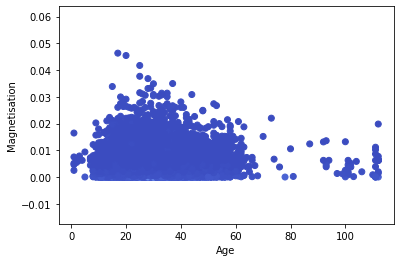

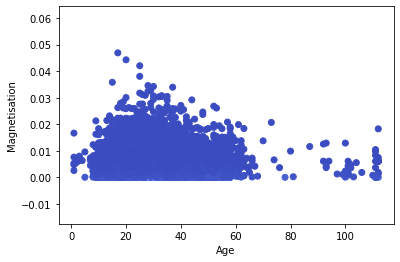

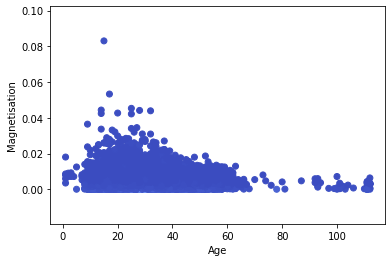

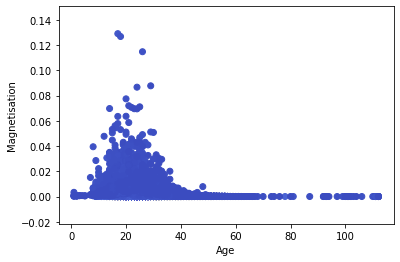

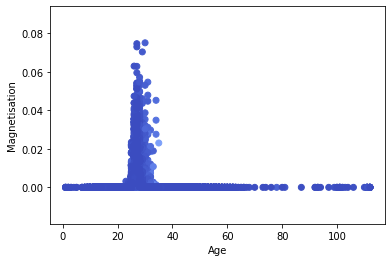

In [38]:
from scipy import stats
spearmans_age=[]
spearmans_degree=[]
for index,gradient in enumerate(grad_vals) :
    this_grad=gradient_data.loc[gradient_data['gradient']==gradient]['mag_gradient'].to_list()
    this_m=gradient_data.loc[gradient_data['gradient']==gradient]['m'].to_list()
    # Also get the magnetisation out
    fig,ax=plt.subplots()
    #plt.plot([k+j for k,j in zip(background_field,degrees)],this_grad,'bo')
    # plt.plot(ages,this_grad,'bo')
    ax.scatter(ages,this_grad,c=degrees,cmap='coolwarm')
    #plt.plot(ages,this_m,'bo')
    plt.xlabel("Age")
    plt.ylabel("Magnetisation")
    #plt.yscale('log')
    spearmans_age.append(stats.spearmanr(background_field,this_grad)[0])
    spearmans_degree.append(stats.spearmanr(degrees,this_grad)[0])

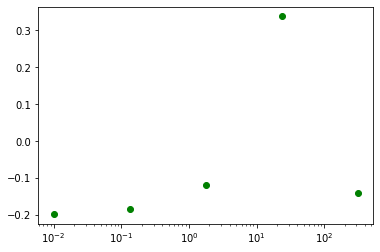

In [20]:
plt.plot(grad_vals,spearmans_age,'go')
plt.xscale('log')

In [18]:
spearmans_degree

[SpearmanrResult(correlation=-0.8959729462246214, pvalue=0.0),
 SpearmanrResult(correlation=-0.8962680847204468, pvalue=0.0),
 SpearmanrResult(correlation=-0.89827829787769, pvalue=0.0),
 SpearmanrResult(correlation=-0.6170913463840862, pvalue=0.0),
 SpearmanrResult(correlation=-0.04811045547460261, pvalue=1.2404406089440103e-16)]

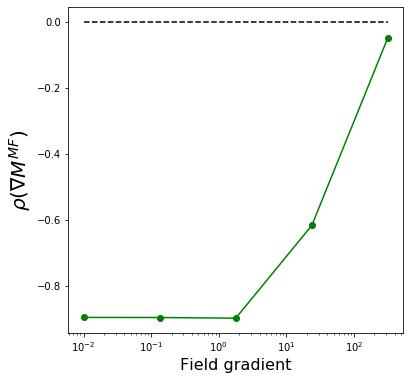

In [33]:
fig,ax=plt.subplots(figsize=(6,6))
plt.plot(grad_vals,spearmans_degree,'go-')
plt.xscale('log')
plt.ylabel("$\\rho(\\nabla M^{MF})$",fontsize=20)
plt.xlabel("Field gradient",fontsize=16)
plt.plot(grad_vals,np.zeros(len(grad_vals)),'k--')

In [ ]:
plt.plot(degrees,m_full,'bo')

In [ ]:
plt.plot(ages,m_full,'bo')

In [ ]:
# Test analysis

plt.plot(background_field,mag_grad_full,'bo')

In [ ]:
plt.plot(degrees,mag_grad_full,'bo')
# Compare with exponential decay.
plt.yscale('log')